# Unsupervised Learning

### Fetching Data from Digits

### TODO list :
- Mettre une image de Silhouette score

In [2]:
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as npy
import time
from sklearn.cluster import KMeans


### Fetching data from MlData (optional )

In [2]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

mnist=fetch_mldata('MNIST original',data_home=".")
sampleIndex=npy.random.randint(70000,size=5000)
baseData=mnist.data[sampleIndex]
baseTarget=mnist.target[sampleIndex]
dataTrain,dataTest,targetTrain,targetTest=train_test_split(baseData,baseTarget,train_size=0.7)


/home/chivunito/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [10]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
digits=load_digits()
data,target=digits['data'],digits['target']
dataTrain,dataTest,targetTrain,targetTest=train_test_split(data,target,test_size=0.3)


## Plotting digit

183


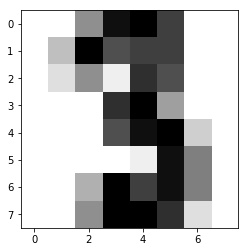

In [106]:
from random import randint

# Plot an image according to a given number
def plotImage(number):
    numberToPlot=data[target==number]
    print(len(numberToPlot))
    if len(numberToPlot):
        index=randint(0,len(numberToPlot)-1)
        imageToPlot=npy.reshape(numberToPlot[index],(8,8))
        plt.imshow(imageToPlot, cmap=plt.cm.gray_r, interpolation='none')
        plt.show()
    else : 
        print("Not a good Number to plot")
plotImage(3)

### Scoring K-Means
Afin de scorer l'algorithme K-means, nous utiliserons la méthode __.silhouette_score()__ qui calcule la moyenne des "__Silhouette Coefficient__" pour tous les points.
__Silhouette Coefficient__ : Pour un point donné, on va s'intéresser à la distance de celui-ci par rapport à son centroïde (__a__) et la distance avec le centroïde du cluster voisin le plus proche (__b__). <br> 

Le Silhouette Coefficient vaut alors : <br>
__$SlC =  (b - a) / max(a,b) $__ <br>
- Ainsi, si le point est très proche de son centroïde, et le cluster voisin est loin, $SlC => 1$ 

- A l'inverse $SlC => -1 $ signifie que le point n'appartient pas au bon cluster
- $SlC = 0 $ Signifie que les clusters se chevauchent

Nous chercherons donc à avoir un score proche de 1 dans la suite de nos tests

http://scikitlearn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [13]:
from sklearn.metrics import silhouette_score

def scoreKmeans(k=10, init='k-means++',n_init=60,max_iter=500,dataTrain=dataTrain,dataTest=dataTest,targetTrain=targetTrain,targetTest=targetTest) : 
    summary={}
    clustering=KMeans(n_clusters=k, init=init,n_init=n_init,max_iter=max_iter)
    startTime=time.time()
    clustering.fit(dataTrain,targetTrain)
    predictedTarget=clustering.predict(dataTest)
    score=silhouette_score(dataTest,predictedTarget)
    summary['time']=time.time()-startTime
    summary['score']=score
    summary['k']=k
    summary['init']=init
    return summary

In [14]:
# Testing
scoreKmeans()

{'init': 'k-means++',
 'k': 10,
 'score': 0.19024594208267176,
 'time': 0.9610757827758789}

## Variation du nombre de clusters & seeds

In [17]:
# clustering=KMeans(n_clusters=10, init='k-means++',n_init=10)
seeds=['random','k-means++']
summaryList=[]
for seed in seeds : 
    for k in range(2,15):
        summary=scoreKmeans(k=k,init=seed,dataTrain=dataTrain,dataTest=dataTest,targetTrain=targetTrain,targetTest=targetTest)
        summaryList+=[summary]
#     print(summary)

### plotting result

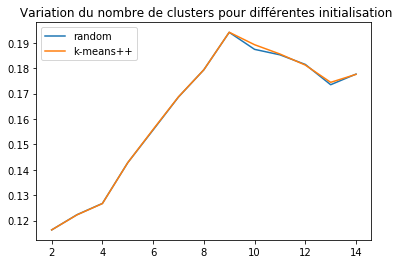

In [19]:
for seed in seeds : 
    score=npy.array([(x['k'],x['score']) for x in summaryList if x['init']==seed])
    plt.plot(score[:,0],score[:,1],label=seed)
plt.legend()
plt.title(" Variation du nombre de clusters pour différentes initialisation")
plt.show()


### Analyse en composantes principales

In [21]:
from sklearn.decomposition import PCA

def varPCA(n_components=8,k_constant=9) :
    pca = PCA(n_components=n_components)
    data,target=digits['data'],digits['target']
    newData=pca.fit_transform(data)
    dataTrain,dataTest,targetTrain,targetTest=train_test_split(newData,target,test_size=0.3)
    print('PCA',len(dataTrain[0]))
    summary=scoreKmeans(k=k_constant,dataTrain=dataTrain,dataTest=dataTest,targetTrain=targetTrain,targetTest=targetTest)
    return summary

In [24]:
summaryList=[]
for n_components in range(2,50):
    summary=varPCA(n_components=n_components)
    summary['PCA']=n_components
    summaryList+=[summary]

PCA 2
PCA 3
PCA 4
PCA 5
PCA 6
PCA 7
PCA 8
PCA 9
PCA 10
PCA 11
PCA 12
PCA 13
PCA 14
PCA 15
PCA 16
PCA 17
PCA 18
PCA 19
PCA 20
PCA 21
PCA 22
PCA 23
PCA 24
PCA 25
PCA 26
PCA 27
PCA 28
PCA 29
PCA 30
PCA 31
PCA 32
PCA 33
PCA 34
PCA 35
PCA 36
PCA 37
PCA 38
PCA 39
PCA 40
PCA 41
PCA 42
PCA 43
PCA 44
PCA 45
PCA 46
PCA 47
PCA 48
PCA 49


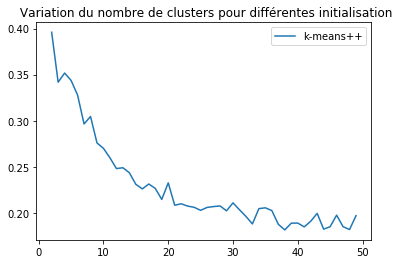

In [23]:
score=npy.array([(x['PCA'],x['score']) for x in summaryList])
plt.plot(score[:,0],score[:,1],label=seed)

plt.legend()
plt.title(" Variation du nombre de clusters pour différentes initialisation")
plt.show()


n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.24s	69432	0.602	0.650	0.625	0.465	0.598	0.146
random   	0.30s	69694	0.669	0.710	0.689	0.553	0.666	0.147
PCA-based	0.07s	70804	0.671	0.698	0.684	0.561	0.668	0.118
__________________________________________________________________________________


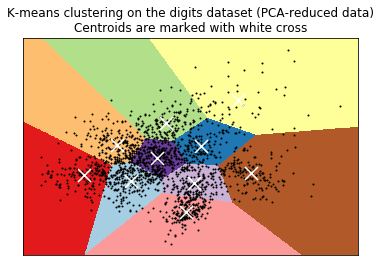

In [14]:
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans


npy.random.seed(42)
digits = load_digits()
data = scale(digits.data)
n_samples, n_features = data.shape
n_digits = len(npy.unique(digits.target))
labels = digits.target
sample_size = 300
print("n_digits: %d, \t n_samples %d, \t n_features %d" % (n_digits, n_samples, n_features))
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
def bench_k_means(estimator, name, data):
    t0 = time.time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f' % (name, (time.time() - t0), estimator.inertia_,
    metrics.homogeneity_score(labels, estimator.labels_),
    metrics.completeness_score(labels, estimator.labels_),
    metrics.v_measure_score(labels, estimator.labels_),
    metrics.adjusted_rand_score(labels, estimator.labels_),
    metrics.adjusted_mutual_info_score(labels, estimator.labels_),
    metrics.silhouette_score(data, estimator.labels_,metric='euclidean',sample_size=sample_size)))
    
bench_k_means(KMeans(init='k-means++',n_clusters=n_digits,n_init=10), name="k-means++", data=data)
bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),name="random", data=data)
# # in this case the seeding of the centers is deterministic, hence
# # we run the kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_,n_clusters=n_digits,n_init=1),name="PCA-based",data=data)
print(82 * '_')

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02
# point in the mesh [x_min, x_max]x[y_min, y_max].
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:,
0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:,
1].max() + 1
xx, yy = npy.meshgrid(npy.arange(x_min, x_max, h), npy.arange(y_min,
y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(npy.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
extent=(xx.min(), xx.max(), yy.min(), yy.max()),
cmap=plt.cm.Paired,
aspect='auto', origin='lower')
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
marker='x', s=169, linewidths=3,
color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

